In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
from standardize import *

## Load the training data into feature matrix, class labels, and event ids:

In [3]:
from proj1_helpers import *
DATA_TRAIN_PATH = 'C:/Users/franc/OneDrive/Università/EPFL/MA3/ML_course/projects/project1/data/train.csv/train.csv'# TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [4]:
n_feats = tX.shape[1]
n_data = tX.shape[0]

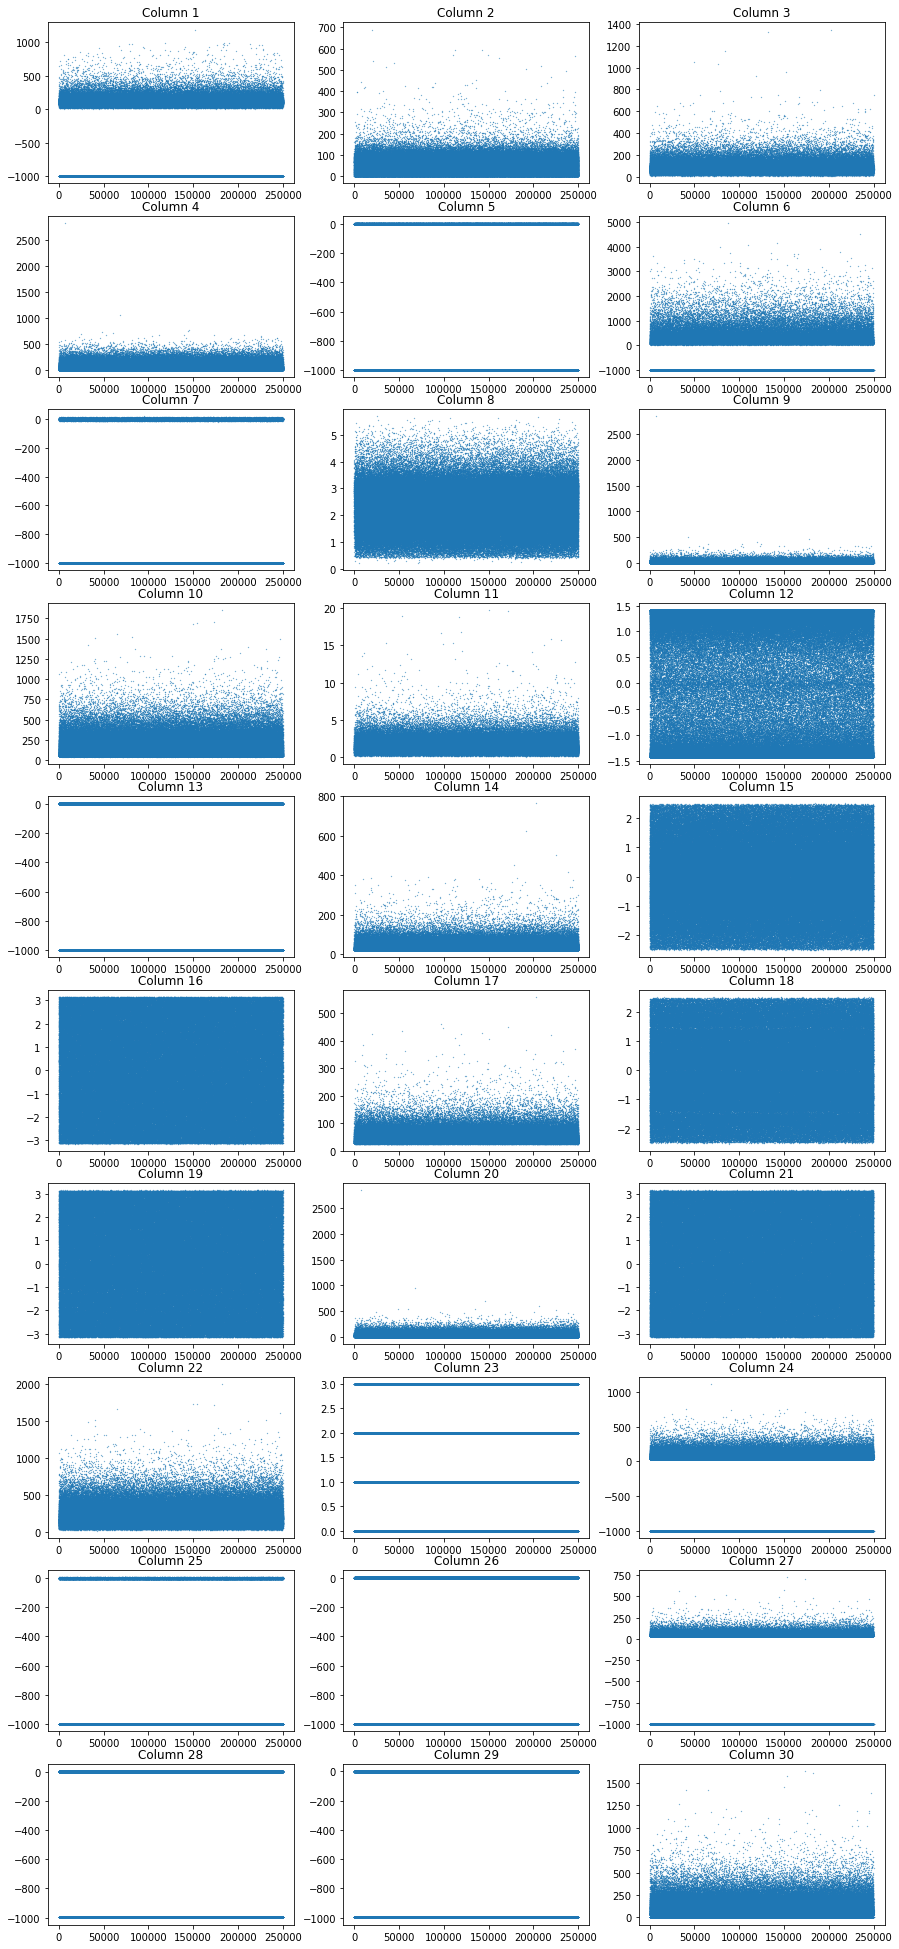

In [5]:
fig = plt.figure(figsize=(15, 35))
for i in range(30):
    ax = fig.add_subplot(10, 3, i+1)
    plt.plot(range(n_data), tX[:, i], 'o', markersize = 0.25)
    plt.title("Column {c}".format(c = i+1))

Text(0.5, 0, 'Column number')

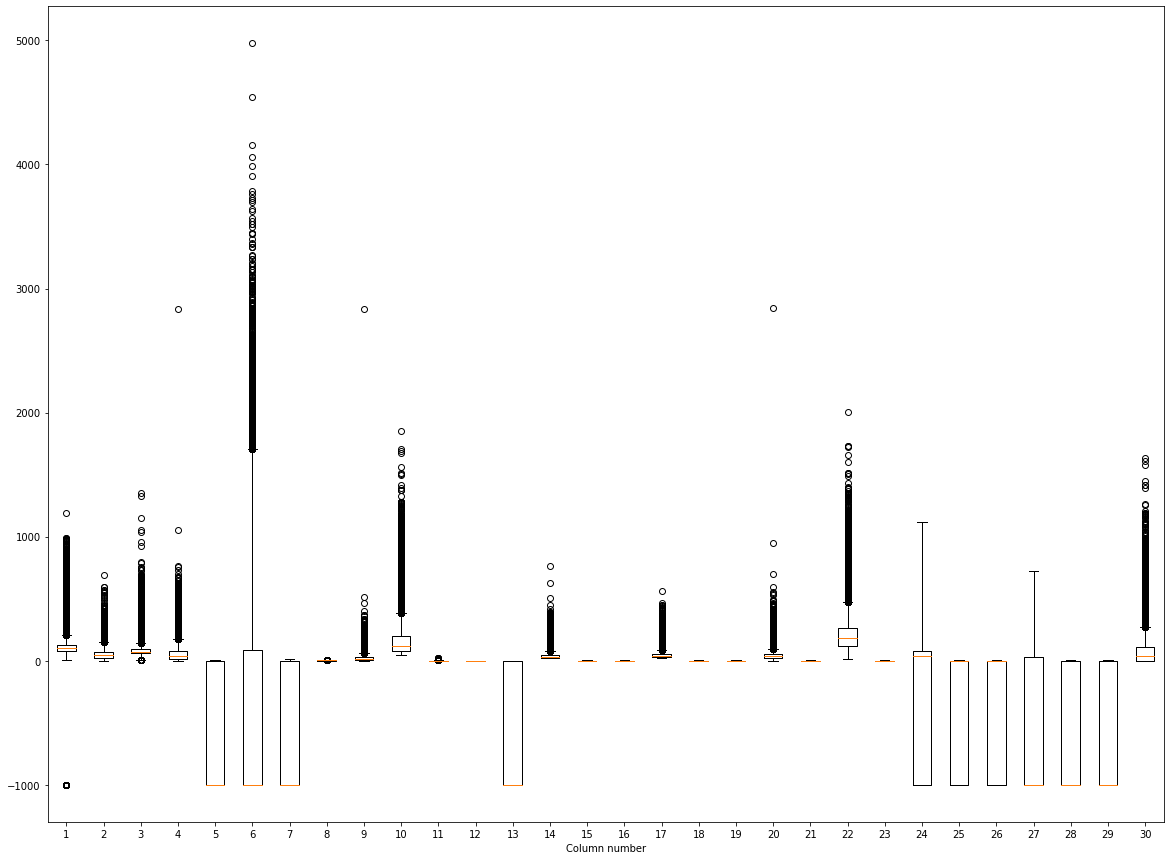

In [6]:
fig = plt.figure(figsize = (20, 15))
ax = plt.boxplot(tX)
plt.xlabel("Column number")

## Preprocess the data
I will try to apply the least squares (using normal equaitions) to the data. I could use a mini batch.
But first I need to remove the outlier (visible in columns 4, 9 and 20), standardize the data and change the categorical column.


In [7]:
for i in [3, 8, 19]:
    o = np.where(tX[:, 3]>2000)
    print('In the {l} column, the {k} element is outlier'.format(l=i, k=o))

In the 3 column, the (array([7343], dtype=int64),) element is outlier
In the 8 column, the (array([7343], dtype=int64),) element is outlier
In the 19 column, the (array([7343], dtype=int64),) element is outlier


In [8]:
# Remove the outlier
tX = np.delete(tX, 7343, axis=0)
y = np.delete(y, 7343, axis=0)
tX.shape
y.shape

(249999,)

In [9]:
# Split the categorical column into several columns
def data_into_cat(tX, col_num):
    for i in np.unique(tX[:, col_num]):
        inds = np.where(tX[:, col_num]==i)
        pri_jet = np.zeros(tX.shape[0])
        pri_jet[inds]=1
        tX = np.column_stack((tX, pri_jet))
    tX = np.delete(tX, col_num, axis=1)
    print("The shape of the new matrix is: "+str(tX.shape))
    return tX
tX = data_into_cat(tX, 22)

The shape of the new matrix is: (249999, 33)


In [10]:
# Standardize the features
tX_s = standardize(tX)

Now as there are a few columns like the first one (i.e. with severalò -999 values) we will create a reduced dataset without those. 

In [11]:
count_missing = np.count_nonzero(tX == -999, axis=0)
print(count_missing)
cols_missing = np.where(count_missing != 0)
print(cols_missing)

[ 38114      0      0      0 177456 177456 177456      0      0      0
      0      0 177456      0      0      0      0      0      0      0
      0      0  99912  99912  99912 177456 177456 177456      0      0
      0      0      0]
(array([ 0,  4,  5,  6, 12, 22, 23, 24, 25, 26, 27], dtype=int64),)


Eleven of the 30 features have a significant amount of -999 values. Now we can count any zeros:

In [12]:
print(np.count_nonzero(tX == 0, axis=0))

[     0      3      0     41      6      0     58      0     39      0
      0     53  15752      0      0     32      0     35     33      0
     44      0      0     26     19      0      9     10  99912 150087
 172455 199620 227835]


In [13]:
# Check for NaNs
np.isnan(np.sum(tX))
# If false, there are no NaN values

False

Here, I removed features with -999 values, but we will re-do this after and keep them

In [13]:
tX_reduced = tX_s.copy()
tX_reduced = np.delete(tX_reduced, cols_missing, axis = 1)
print(tX.shape)
print(tX_reduced.shape)

(249999, 33)
(249999, 22)


# Least squares
We will try to make a model with the least squares. We will try to implement it on a mini batch and maybe with a polynomial feature expansion

In [15]:
from batch_iter import *
from build_polynomial import*
from least_squares import*

In [16]:
def least_squares_demo(y, tx, batch_size, max_iters=1):
    """Stochastic gradient descent algorithm."""
       
    # Define parameters to store w and loss
    ws = []
    losses = []
    (y, tx) = next(batch_iter(y, tx, batch_size))
    loss, w = least_squares(y, tx)
    
    # store w and loss
    ws.append(w)
    losses.append(loss)
        
    return losses, ws

In [60]:
# Visualize the distribution of the results
def vis_results_ls(results, y, yes, no, figure=True):
    #Split the data into -1 and 1
    ids_yes = np.where(y == yes)
    ids_no = np.where(y == no)
    if figure:
        plt.figure(figsize=(10, 10))
    plt.hist(results[ids_yes], 50, density=False, alpha=0.5, label="1 values")
    plt.hist(results[ids_no], 50, density=False, alpha=0.5, label="-1 values")
    plt.axvline(x=yes, color = 'r')
    plt.axvline(x=no, color ='r')
    plt.axvline(x=np.mean([yes, no]), color = 'b', linestyle='dashed')
    plt.xlabel("Predictions")
    plt.ylabel("Density")
    leg = plt.legend(loc=1, shadow=True)
    leg.draw_frame(False);

In [18]:
#Make the results into two categories
def results_to_cat(results, th, yes, no):
    res_no = np.where(results<th)
    res_yes = np.where(results>=th)
    res_cat = np.zeros(len(results))
    res_cat[res_no]=no
    res_cat[res_yes]=yes
    return res_cat

For a degree of 1, the results have a minimum of -4.355661843931102 and a maximum of 4.98834963625967
The train accuracy of the model is 0.7468269873079493
For a degree of 2, the results have a minimum of -14.975119305658154 and a maximum of 4.270415014136233
The train accuracy of the model is 0.7711430845723383
For a degree of 3, the results have a minimum of -5.708033802220598 and a maximum of 7.281848473008722
The train accuracy of the model is 0.7757071028284113
For a degree of 4, the results have a minimum of -5.408349341712892 and a maximum of 12.325851530767977
The train accuracy of the model is 0.78687114748459
For a degree of 5, the results have a minimum of -14.735269305092515 and a maximum of 3.882875408278778
The train accuracy of the model is 0.7960991843967375


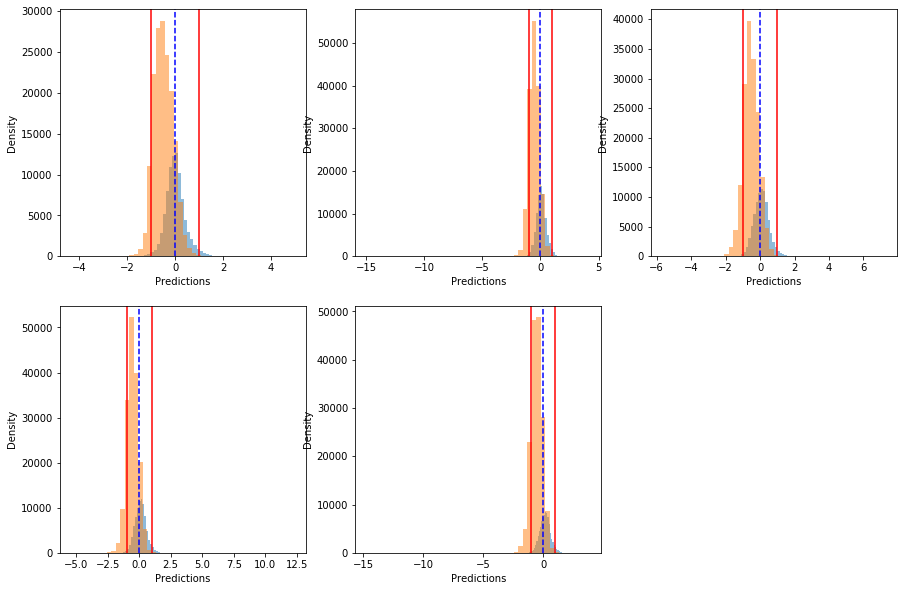

In [41]:
# Try with different batch sizes and polynomial degrees for teh feature expansion
batch_size = len(y)
results = []
fig = plt.figure(figsize=(15, 10))
# Try with 5 degrees
for degree in np.arange(5)+1:
    tX_poly = build_poly(tX_s, degree)
    losses, w = least_squares_demo(y, tX_poly, batch_size)
    results.append(tX_poly.dot(w[0]))
    print("For a degree of {d}, the results have a minimum of {mi} and a maximum of {mx}".format(d=degree, mi=results[degree-1].min(), mx=results[degree-1].max()))
    ax = fig.add_subplot(2, 3, degree)
    vis_results_ls(results[degree-1], y, 1, -1, figure=False)
    
    # Find the accuracy
    res_cat = results_to_cat(results[degree-1], 0, 1, -1)
    acc = np.sum(res_cat==y)/len(y)
    print("The TRAIN accuracy of the model is {a}".format(a=acc))

Here above I am showing the hisograms of the predictions made. The blue one represents the predictions that should be 1. The orange one represents the predictions that should be -1.
I have also tried the mini batch but since without it it doesn't take long to train I don't see the point of using it

## Test the model
Here I am going to test the model (the ws found) onto the test dataset

In [42]:
#Upload the test data and modify it as in the train
DATA_TEST_PATH = 'C:/Users/franc/OneDrive/Università/EPFL/MA3/ML_course/projects/project1/data/test.csv/test.csv'
y_te, tX_te, ids_te = load_csv_data(DATA_TEST_PATH)

In [43]:
# Should I look for outliers in the test set? I guess no. Anyways
for i in [3, 8, 19]:
    o = np.where(tX_te[:, 3]>2000)
    print('In the {l} column, the {k} element is outlier'.format(l=i, k=o))

In the 3 column, the (array([], dtype=int64),) element is outlier
In the 8 column, the (array([], dtype=int64),) element is outlier
In the 19 column, the (array([], dtype=int64),) element is outlier


In [44]:
# Rearrange the categorical column
tX_te = data_into_cat(tX_te, 22)
# Standardize the features
tX_te_s = standardize(tX_te)

The shape of the new matrix is: (568238, 33)


In [45]:
tX_te_reduced = tX_te_s.copy()
tX_te_reduced = np.delete(tX_te_reduced, cols_missing, axis = 1)
print(tX_te_s.shape)
print(tX_te_reduced.shape)

(568238, 33)
(568238, 22)


For a degree of 1, the results have a minimum of -7.889247627731493 and a maximum of 8.374954758768013
The TRAIN accuracy of the model is 0.7468269873079493
The TEST accuracy of the model is 0.3256311615907419

For a degree of 2, the results have a minimum of -1294.287638347363 and a maximum of 1174.8320846508723
The TRAIN accuracy of the model is 0.7702070808283233
The TEST accuracy of the model is 0.48967510092602046

For a degree of 3, the results have a minimum of -2502.268508807465 and a maximum of 2122.745492862756
The TRAIN accuracy of the model is 0.7773591094364377
The TEST accuracy of the model is 0.2911491311739095

For a degree of 4, the results have a minimum of -1027.922258288134 and a maximum of 7824.654424790962
The TRAIN accuracy of the model is 0.7863911455645822
The TEST accuracy of the model is 0.7982394700811983

For a degree of 5, the results have a minimum of -3035.4924183026887 and a maximum of 11439.22289763068
The TRAIN accuracy of the model is 0.7959911839647

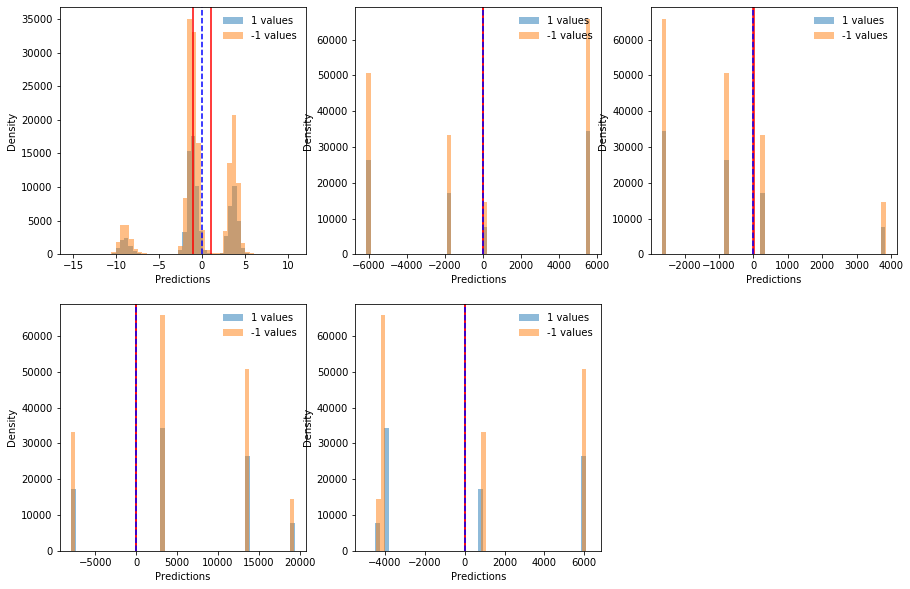

In [61]:
# Try with different batch sizes and polynomial degrees for teh feature expansion
batch_size = len(y)
results_te = []
results_tr = []
acc_tr = []
acc_te = []
fig = plt.figure(figsize=(15, 10))
# Try with 5 degrees
for degree in np.arange(5)+1:
    tX_tr_poly = build_poly(tX_s, degree)
    tX_te_poly = build_poly(tX_te_s, degree)
    
    losses, w = least_squares_demo(y, tX_tr_poly, batch_size)
    results_tr.append(tX_tr_poly.dot(w[0]))
    results_te.append(tX_te_poly.dot(w[0]))
    
    print("For a degree of {d}, the results have a minimum of {mi} and a maximum of {mx}".format(d=degree, mi=results[degree-1].min(), mx=results[degree-1].max()))
    ax = fig.add_subplot(2, 3, degree)
    vis_results_ls(results_te[degree-1], y, 1, -1, figure=False)
    
    # Find the accuracy
    res_cat_tr = results_to_cat(results_tr[degree-1], 0, 1, -1)
    res_cat_te = results_to_cat(results_te[degree-1], 0, 1, -1)
    acc_tr.append(np.sum(res_cat_tr==y)/len(y))
    acc_te.append(np.sum(res_cat_te==y_te)/len(y_te))
    print("The TRAIN accuracy of the model is {a}".format(a=acc_tr[degree-1]))
    print("The TEST accuracy of the model is {a}\n".format(a=acc_te[degree-1]))

### NOTE
If you re-reun the code above You will notice that the TEST accuracy changes

I will now try to see how it works with the reduced set

For a degree of 1, the results have a minimum of -7.889247627731493 and a maximum of 8.374954758768013
The TRAIN accuracy of the model is 0.7358789435157741
The TEST accuracy of the model is 0.28817678507949135

For a degree of 2, the results have a minimum of -1294.287638347363 and a maximum of 1174.8320846508723
The TRAIN accuracy of the model is 0.7556390225560903
The TEST accuracy of the model is 0.3557312252964427

For a degree of 3, the results have a minimum of -2502.268508807465 and a maximum of 2122.745492862756
The TRAIN accuracy of the model is 0.7603870415481662
The TEST accuracy of the model is 0.2448639478528363

For a degree of 4, the results have a minimum of -1027.922258288134 and a maximum of 7824.654424790962
The TRAIN accuracy of the model is 0.7675110700442802
The TEST accuracy of the model is 0.3113343352609294

For a degree of 5, the results have a minimum of -3035.4924183026887 and a maximum of 11439.22289763068
The TRAIN accuracy of the model is 0.7719430877723

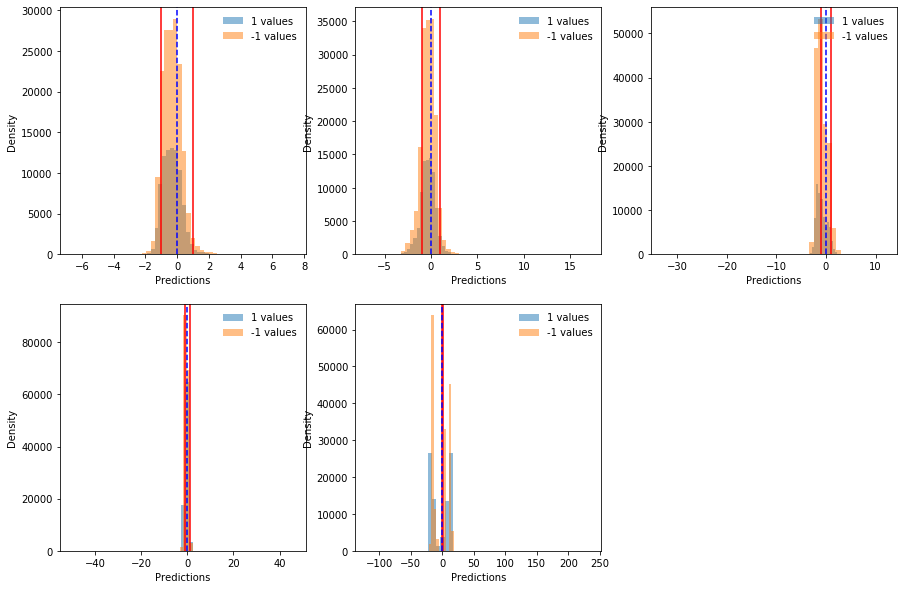

In [62]:
# Try with different batch sizes and polynomial degrees for teh feature expansion
batch_size = len(y)
results_te = []
results_tr = []
acc_tr = []
acc_te = []
fig = plt.figure(figsize=(15, 10))
# Try with 5 degrees
for degree in np.arange(5)+1:
    tX_tr_poly = build_poly(tX_reduced, degree)
    tX_te_poly = build_poly(tX_te_reduced, degree)
    
    losses, w = least_squares_demo(y, tX_tr_poly, batch_size)
    results_tr.append(tX_tr_poly.dot(w[0]))
    results_te.append(tX_te_poly.dot(w[0]))
    
    print("For a degree of {d}, the results have a minimum of {mi} and a maximum of {mx}".format(d=degree, mi=results[degree-1].min(), mx=results[degree-1].max()))
    ax = fig.add_subplot(2, 3, degree)
    vis_results_ls(results_te[degree-1], y, 1, -1, figure=False)
    
    # Find the accuracy
    res_cat_tr = results_to_cat(results_tr[degree-1], 0, 1, -1)
    res_cat_te = results_to_cat(results_te[degree-1], 0, 1, -1)
    acc_tr.append(np.sum(res_cat_tr==y)/len(y))
    acc_te.append(np.sum(res_cat_te==y_te)/len(y_te))
    print("The TRAIN accuracy of the model is {a}".format(a=acc_tr[degree-1]))
    print("The TEST accuracy of the model is {a}\n".format(a=acc_te[degree-1]))

# Ridge regression
Try the ridge regression now. Use the two sets (tX_s and tX_reduced)

In [75]:
from ridge_regression import*
from costs import*
def ridge_regression_demo(y, tX, y_te, tX_te, degree):
    """Stochastic gradient descent algorithm."""
       
    # Define parameters to store w and loss
    lambdas = np.logspace(-5, 5, 15)
    ws = []
    rmse_tr = []
    rmse_te = []
    
    for ind, lambda_ in enumerate(lambdas):
        w = ridge_regression(y, tX, lambda_)
        mse_tr = compute_loss(y, tX, w)
        mse_te = compute_loss(y_te, tX_te, w)
        # store w and loss
        ws.append(w)
        rmse_tr.append(np.sqrt(2*mse_tr))
        rmse_te.append(np.sqrt(2*mse_te))
        print("lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    plt.semilogx(lambdas, rmse_tr, color='b', marker='*', label="Train error")
    plt.semilogx(lambdas, rmse_te, color='r', marker='*', label="Test error")
    plt.xlabel("lambda")
    plt.ylabel("RMSE")
    plt.title("Ridge regression for polynomial degree " + str(degree))
    leg = plt.legend(loc=1, shadow=True)
    leg.draw_frame(False)
    return ws, rmse_tr, rmse_te

lambda=0.000, Training RMSE=0.824, Testing RMSE=1.396
lambda=0.000, Training RMSE=0.824, Testing RMSE=1.396
lambda=0.000, Training RMSE=0.824, Testing RMSE=1.396
lambda=0.001, Training RMSE=0.824, Testing RMSE=1.394
lambda=0.007, Training RMSE=0.825, Testing RMSE=1.389
lambda=0.037, Training RMSE=0.830, Testing RMSE=1.382
lambda=0.193, Training RMSE=0.836, Testing RMSE=1.378
lambda=1.000, Training RMSE=0.841, Testing RMSE=1.377
lambda=5.179, Training RMSE=0.844, Testing RMSE=1.376
lambda=26.827, Training RMSE=0.846, Testing RMSE=1.372
lambda=138.950, Training RMSE=0.852, Testing RMSE=1.361
lambda=719.686, Training RMSE=0.870, Testing RMSE=1.342
lambda=3727.594, Training RMSE=0.892, Testing RMSE=1.326
lambda=19306.977, Training RMSE=0.907, Testing RMSE=1.309
lambda=100000.000, Training RMSE=0.920, Testing RMSE=1.290
For a degree of 1, the results have a minimum of -7.889247627731493 and a maximum of 8.374954758768013
The TRAIN accuracy of the model is 0.6513386053544215
The TEST accurac

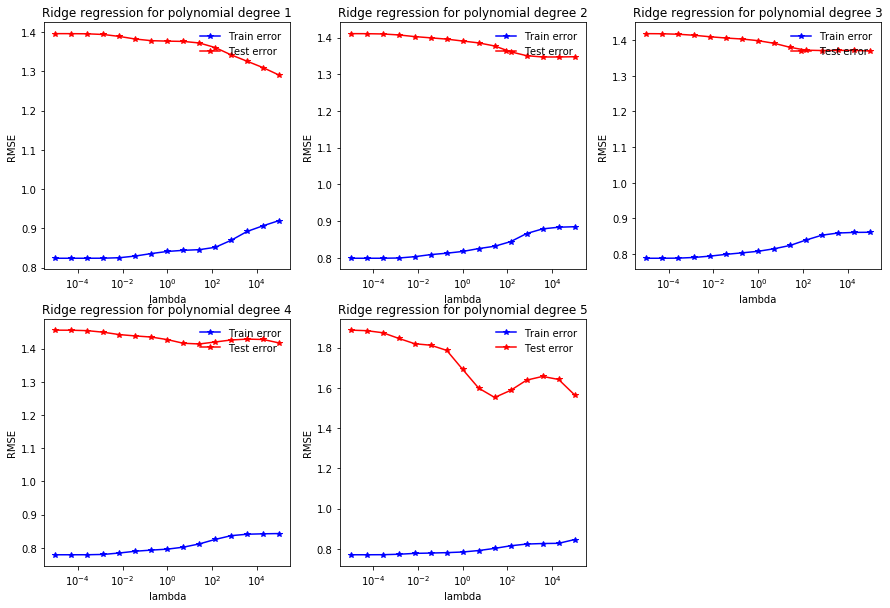

In [77]:
degree = 1
results_te = []
results_tr = []
acc_tr = []
acc_te = []
fig = plt.figure(figsize=(15, 10))

for degree in np.arange(5)+1:
    tX_tr_poly = build_poly(tX, degree)
    tX_te_poly = build_poly(tX_te, degree)
    
    ax = fig.add_subplot(2, 3, degree)
    w, rmse_tr, rmse_te = ridge_regression_demo(y, tX_tr_poly, y_te, tX_te_poly, degree)
    results_tr.append(tX_tr_poly.dot(w[-1]))
    results_te.append(tX_te_poly.dot(w[-1]))

    print("For a degree of {d}, the results have a minimum of {mi} and a maximum of {mx}".format(d=degree, mi=results[degree-1].min(), mx=results[degree-1].max()))
    #vis_results_ls(results_te[degree-1], y, 1, -1, figure=False)

    # Find the accuracy
    res_cat_tr = results_to_cat(results_tr[degree-1], 0, 1, -1)
    res_cat_te = results_to_cat(results_te[degree-1], 0, 1, -1)
    acc_tr.append(np.sum(res_cat_tr==y)/len(y))
    acc_te.append(np.sum(res_cat_te==y_te)/len(y_te))
    print("The TRAIN accuracy of the model is {a}".format(a=acc_tr[degree-1]))
    print("The TEST accuracy of the model is {a}\n".format(a=acc_te[degree-1]))

# FUNCTIONS

In [17]:
def sigmoid(t):
    """apply the sigmoid function on t."""
    return 1 / (1 + np.exp(-t))

In [18]:
def calculate_gradient(y, tx, w):
    """compute the gradient of loss."""
    return tx.T.dot(sigmoid(tx.dot(w))-y)

In [19]:
def calculate_hessian(y, tx, w):
    """return the Hessian of the loss function."""
    diagVal = np.squeeze(np.multiply(sigmoid(tx.dot(w)), 1 - sigmoid(tx.dot(w))))
    S = np.diag(diagVal)

    return tx.T.dot(S).dot(tx)

In [20]:
def calculate_loss(y, tx, w):
    """compute the loss: negative log likelihood."""
    return np.sum(np.log(1+np.exp(tx.dot(w))) - np.multiply(y, tx.dot(w)))

In [21]:
def logistic_regression(y, tx, w):
    """return the loss, gradient, and Hessian."""

    loss = calculate_loss(y, tx, w)
    grad = calculate_gradient(y, tx, w)
    hess = calculate_hessian(y, tx, w) 
    
    return loss, grad, hess

In [80]:
def learning_by_gradient_descent(y, tx, w, gamma):
    """
    Do one step of gradient descent using logistic regression.
    Return the loss and the updated w.
    """
    grad = calculate_gradient(y, tx, w)
    w = w - gamma*grad
    
    return w

In [94]:
calculate_gradient(y, tX, w)

MemoryError: 

In [95]:
tX.shape

(250000, 30)

In [81]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [84]:
from build_polynomial import build_poly

def cross_validation(y, x, k_indices, k, max_iter, threshold, gamma, degree=1):
    """return the loss of ridge regression."""
    x_tr = x[k_indices][np.arange(len(k_indices))!=k].ravel()
    x_te = x[k_indices][k].ravel()
    y_tr = y[k_indices][np.arange(len(k_indices))!=k].ravel()
    y_te = y[k_indices][k].ravel()
    
    #x_tr = build_poly(x_tr, degree)
    #x_te = build_poly(x_te, degree)
    
    w = np.zeros((x.shape[1], 1))
    # start the logistic regression
    for iter in range(max_iter):
        #ger loss and update w
        w = learning_by_gradient_descent(y_tr, x_tr, w, gamma)
        loss_tr = calculate_loss(y_tr, x_tr, w)
        loss_te = calculate_loss(y_te, x_te, w)
        
        losses_tr.append(loss_tr)
        losses_te.append(loss_te)
        if len(losses_te) > 1 and np.abs(losses_te[-1] - losses_te[-2]) < threshold:
            break
        print("loss={l}".format(l=calculate_loss(y, tx, w)))
    return losses_tr, losses_te

In [86]:
def cross_validation_demo(y, x):
    seed = 1
    degree = 1
    k_fold = 4
    
    max_iter = 10000
    threshold = 1e-8
    gamma = 0.01
    
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    
    for k in range(k_fold):
        loss_tr_k, loss_te_k = cross_validation(y, x, k_indices, k, max_iter, threshold, gamma, degree)
        loss_tr.append(loss_tr_k)
        loss_te.append(loss_te_k)
    loss_tr = np.sum(loss_tr)/k_fold
    loss_te = np.sum(loss_te)/k_fold
        
    rmse_tr.append(np.sqrt(2*loss_tr))
    rmse_te.append(np.sqrt(2*loss_te))
        

In [89]:
cross_validation_demo(y, tX)

ValueError: shapes (5625000,2) and (30,1) not aligned: 2 (dim 1) != 30 (dim 0)

In [91]:
w = np.zeros((tX.shape[1], 1))

In [92]:
w.shape

(30, 1)

## Do your thing crazy machine learning thing here :) ...

## Generate predictions and save ouput in csv format for submission:

In [10]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [31]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)